# Sentiment Analysis of Game of Thrones wiki - Fandom

#### Chosen characters for sentiment analysis:
 - Cersei Lannister
 - Tyrion Lannister
 - Jon Snow
 - Daenerys Tagaryen
 - Arya Stark

Since there are 389 characters total, there would be too many to analyse and a lot of them are insignificant for this analysis. Thus, we have chosen to conduct sentiment analysis on the 5 characters mentioned above. These were chosen due to their longevity in the series and thus we will be able to conduct a more in-depth analysis. Thus, we will be able to see each character stories throughout the series and what happens to them.  

Additionally we will be able to see if characters is positive/negative/neutral in language, assuming that this will be able to help us see if their stories and actions are negative (war, loosing people, etc.) or positive (finding love, "winning", etc.).

In [1]:
# Importin libraries to get the necessary data (character descriptions from the fandom page)
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from urllib.request import urlopen
from nltk.corpus import stopwords
import json
import nltk
import numpy as np 
from nltk.classify import SklearnClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sentiment = SentimentIntensityAnalyzer()

In [3]:
stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.extend(['tells', 'asks', 'however', 'though', 'also', 'later', 'nt', 'say', 'hound', 'says'])
stop_words = list(stop_words)

In [4]:
CharacterNames = []
with open('characters.json') as json_file:
    data = json.load(json_file)
    for p in data['characters']:
        CharacterNames.append(p['characterName'])
CharacterNames = ' '.join(CharacterNames)
CharacterNames = CharacterNames.split()
CharacterNames = [item.lower() for item in CharacterNames]

In [5]:
FamilyMembers = ['father', 'mother', 'nephew', 'cousin', 'wife', 'brother', 'sister', 'niece', 'son', 'daughter', 
                'surname', 'grandfather', 'grandmother', 'men', 'women', 'brothers', 'daughters', 'children', 'child']

In [6]:
characters = ['Jon Snow', 'Cersei Lannister', 'Tyrion Lannister', 'Daenerys Targaryen', 'Arya Stark']

## Functions to obtain and clean data

In [7]:
def clean_data(text, FamilyMembers, CharacterNames, stop_words):
    digits = '[0-9]'
    symbols = '[!#$%&()*+-./:;<=>?@[\]^_`{|}~\n]'
    
    doc = text
    # remove digits
    doc = [re.sub(digits, '', i) for i in doc]
    # remove symbols
    doc = [re.sub(symbols, '', i) for i in doc]
    # remove single characters
    doc = [re.sub('\\b[^(aiouvAIOUV)]{1} \\b', ' ', i) for i in doc]
    # remove links 
    doc = [re.sub(r'http\S+', '', i) for i in doc]
    # remove punctuation
    doc = [re.sub(r'[^\w\s]', '', i) for i in doc]
    # remove html syntax (\t and \n)
    doc = [re.sub(r'[\t\n\r]', '', i) for i in doc]
    # remove white spaces
    doc = [re.sub('(?<=\n)\s+\n', '', i) for i in doc]
    # stopwords, family member, character names
    doc = [w for w in doc if not w in stop_words]
    doc = [w for w in doc if not w in FamilyMembers]
    doc = [w for w in doc if not w in CharacterNames]

    return doc

### Obtaining relevant text for each character

In [8]:
# Obtaining character description for the 5 chosen characters

def CharDescription(root, endpath):
    path = root+endpath
    req = requests.get(path)
    html_page = req.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)

    output = ''
    blacklist = [
        '[document]',
        'noscript',
        'header',
        'html',
        'meta',
        'head', 
        'input',
        'script',
    # there may be more elements you don't want, such as "style", etc.
    ]
    
    for words in text:
        if words.parent.name not in blacklist:
            output += '{} '.format(words) 

    return soup, text, output
            

In [9]:
def GetSectionName(soup):

    AllH = soup.find_all(['h2', 'h3'])
    for header in AllH:
        if header.span is not None: 
            header.span.unwrap()

    AllHeaders = [header.text for header in AllH]
    if 'Biography' in AllHeaders:
        Pre = AllHeaders.index('Biography')
    elif 'Personality' in AllHeaders: 
        Post = AllHeaders.index('Personality')
    else: 
        print("something went wrong")
        return
    Post = AllHeaders.index('Appearances')

    HeadlineName = AllHeaders[Pre+1:Post]
    return HeadlineName

In [10]:
def GetText(HeadlineNames, soup):
    HeadlineNames += ['Appearances']

    # Unwrap text
    Texts = soup.find_all(['p','h2', 'h3'])
    for section in Texts: 
        if section is not None:
            if section.a is not None: 
                section.a.unwrap()
            elif section.span is not None: 
                section.span.unwrap()

    #S tore text in list
    Texts = [t.text for t in Texts]

    # Find section indices in Texts
    CaptionIndices = []
    for caption in HeadlineNames:         
        CaptionIndices.append(Texts.index(caption))

    # Store texts according to section
    SectionText = []
    for i in range(len(CaptionIndices)-1):
        SectionText.append(Texts[CaptionIndices[i]+1:CaptionIndices[i+1]])


    return SectionText

In [11]:
# Endpaths of the chosen characters

char_wiki = ['/wiki/Jon_Snow',
             '/wiki/Cersei_Lannister',
             '/wiki/Tyrion_Lannister',
             '/wiki/Daenerys_Targaryen',
             '/wiki/Arya_Stark']

In [12]:
root = 'https://gameofthrones.fandom.com'

### Jon Snow

In [13]:
soup_js, text_js, output_js = CharDescription(root, char_wiki[0])
head_js = GetSectionName(soup_js)
js_desc = GetText(head_js, soup_js)
js_list = [j for i in js_desc for j in i]

In [14]:
JS = ' '.join(js_list)
JS = JS.strip()
JS = word_tokenize(JS.lower())

In [15]:
jon = clean_data(JS, CharacterNames, FamilyMembers, stop_words)

In [16]:
jon = [x for x in jon if len(x.strip()) > 0]

In [17]:
# Unique vocabulary for Jon Snow
print(len(set(jon)))

2668


In [18]:
freq = nltk.FreqDist(jon)

In [19]:
freq.most_common(10)

[('not', 80),
 ('wall', 58),
 ('castle', 56),
 ('wildlings', 55),
 ('north', 49),
 ('army', 41),
 ('one', 34),
 ('back', 31),
 ('bastard', 27),
 ('walkers', 27)]

In [20]:
jon_sentiment = ' '.join(str(e) for e in jon)

In [21]:
sentiment.polarity_scores(jon_sentiment)

{'neg': 0.238, 'neu': 0.581, 'pos': 0.18, 'compound': -1.0}

Polarity scores: as one can see, the story of Jon Snow is neither overly positive nor negative, it is mostly neutral at 59.2%. Negative sentiment is at 23.2% and positive at 17.7%.

### Cersei Lannister

In [22]:
soup_cl, text_cl, output_cl = CharDescription(root, char_wiki[1])
head_cl = GetSectionName(soup_cl)
cl_desc = GetText(head_cl, soup_cl)
cl_list = [j for i in cl_desc for j in i]

In [23]:
CL = ' '.join(cl_list)
CL = CL.strip()
CL = word_tokenize(CL.lower())

In [24]:
cersei = clean_data(CL, CharacterNames, FamilyMembers, stop_words)

In [25]:
cersei = [x for x in cersei if len(x.strip()) > 0]

In [26]:
# Unique vocabulary for Cersei Lannister
print(len(set(cersei)))

2571


In [27]:
freq = nltk.FreqDist(cersei)

In [28]:
freq.most_common(10)

[('not', 68),
 ('queen', 31),
 ('one', 27),
 ('would', 26),
 ('death', 25),
 ('trial', 24),
 ('even', 23),
 ('sept', 23),
 ('relationship', 21),
 ('much', 21)]

In [29]:
cersei_sentiment = ' '.join(str(e) for e in cersei)

In [30]:
sentiment.polarity_scores(cersei_sentiment)

{'neg': 0.278, 'neu': 0.545, 'pos': 0.177, 'compound': -1.0}

### Tyrion Lannister

In [31]:
soup_tl, text_tl, output_tl = CharDescription(root, char_wiki[2])
head_tl = GetSectionName(soup_tl)
tl_desc = GetText(head_tl, soup_tl)
tl_list = [j for i in tl_desc for j in i]

In [32]:
TL = ' '.join(tl_list)
TL = TL.strip()
TL = word_tokenize(TL.lower())

In [33]:
tyrion = clean_data(TL, CharacterNames, FamilyMembers, stop_words)

In [34]:
tyrion = [x for x in tyrion if len(x.strip()) > 0]

In [35]:
# Unique vocabulary for Tyrion Lannister
print(len(set(tyrion)))

2855


In [36]:
freq = nltk.FreqDist(tyrion)

In [37]:
freq.most_common(10)

[('not', 67),
 ('city', 34),
 ('one', 30),
 ('hand', 30),
 ('battle', 29),
 ('time', 27),
 ('make', 24),
 ('family', 22),
 ('death', 22),
 ('would', 22)]

In [38]:
tyrion_sentiment = ' '.join(str(e) for e in tyrion)

In [39]:
sentiment.polarity_scores(tyrion_sentiment)

{'neg': 0.259, 'neu': 0.544, 'pos': 0.197, 'compound': -1.0}

### Daenerys Targaryen 

In [40]:
soup_dt, text_dt, output_dt = CharDescription(root, char_wiki[3])
head_dt = GetSectionName(soup_dt)
dt_desc = GetText(head_dt, soup_dt)
dt_list = [j for i in dt_desc for j in i]

In [41]:
DT = ' '.join(dt_list)
DT = DT.strip()
DT = word_tokenize(DT.lower())

In [42]:
dae = clean_data(DT, CharacterNames, FamilyMembers, stop_words)

In [43]:
dae = [x for x in dae if len(x.strip()) > 0]

In [44]:
# Unique vocabulary for Tyrion Lannister
print(len(set(dae)))

3202


In [45]:
freq = nltk.FreqDist(dae)

In [46]:
freq.most_common(10)

[('not', 195),
 ('dragons', 118),
 ('unsullied', 104),
 ('one', 102),
 ('throne', 100),
 ('city', 100),
 ('would', 84),
 ('iron', 77),
 ('army', 76),
 ('take', 72)]

In [47]:
dae_sentiment = ' '.join(str(e) for e in dae)

In [48]:
sentiment.polarity_scores(dae_sentiment)

{'neg': 0.205, 'neu': 0.611, 'pos': 0.184, 'compound': -0.9999}

### Arya Stark

In [49]:
soup_as, text_as, output_as = CharDescription(root, char_wiki[4])
head_as = GetSectionName(soup_as)
as_desc = GetText(head_as, soup_as)
as_list = [j for i in as_desc for j in i]

In [50]:
AS = ' '.join(as_list)
AS = AS.strip()
AS = word_tokenize(AS.lower())

In [51]:
arya = clean_data(AS, CharacterNames, FamilyMembers, stop_words)

In [52]:
arya = [x for x in arya if len(x.strip()) > 0]

In [53]:
# Unique vocabulary for Tyrion Lannister
print(len(set(arya)))

2328


In [54]:
freq = nltk.FreqDist(arya)

In [55]:
freq.most_common(10)

[('not', 55),
 ('one', 46),
 ('would', 29),
 ('needle', 28),
 ('list', 27),
 ('kill', 27),
 ('family', 26),
 ('two', 22),
 ('like', 22),
 ('back', 22)]

In [56]:
arya_sentiment = ' '.join(str(e) for e in arya)

In [57]:
sentiment.polarity_scores(arya_sentiment)

{'neg': 0.258, 'neu': 0.6, 'pos': 0.142, 'compound': -1.0}

## Comparison Between Characters

In [58]:
text = [jon, cersei, tyrion, dae, arya]

In [59]:
data = pd.DataFrame(columns = characters)

In [60]:
import more_itertools as mit

data['Jon Snow'] = list(mit.padded(jon, "", 17201))
data['Cersei Lannister'] = list(mit.padded(cersei, "", 17201))
data['Tyrion Lannister'] = list(mit.padded(tyrion, "", 17201))
data['Daenerys Targaryen'] = list(mit.padded(dae, "", 17201))
data['Arya Stark'] = list(mit.padded(arya, "", 17201))

In [61]:
data

,Jon Snow,Cersei Lannister,Tyrion Lannister,Daenerys Targaryen,Arya Stark
0,artistic,eldest,joanna,youngest,youngest
1,depiction,joanna,died,mad,third
2,abducting,head,giving,sisterwife,born
3,finds,richest,birth,died,raised
4,dying,seven,tragedy,sack,older
...,...,...,...,...,...
17196,,,,,
17197,,,,,
17198,,,,,
17199,,,,,


In [62]:
train, test = train_test_split(data,test_size = 0.1)

In [63]:
train_js = train['Jon Snow']
train_cl = train['Cersei Lannister']
train_tl = train['Tyrion Lannister']
train_dt = train['Daenerys Targaryen']
train_as = train['Arya Stark']

In [64]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if word != 'edd'
                            and word != 'nt'
                            and word != 'one' 
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(5, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

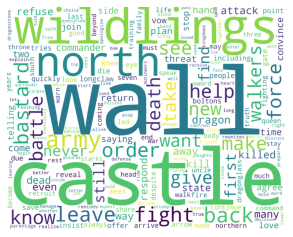

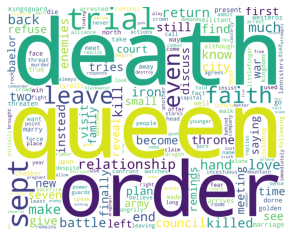

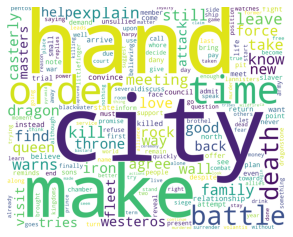

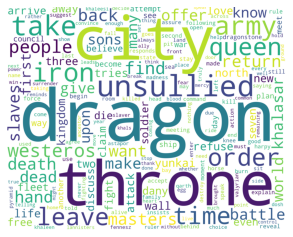

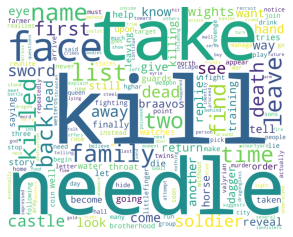

In [65]:
wordcloud_draw(train_js, 'white')
wordcloud_draw(train_cl, 'white')
wordcloud_draw(train_tl, 'white')
wordcloud_draw(train_dt, 'white')
wordcloud_draw(train_as, 'white')